# Intro to the usage of the genericVAE

## Accessability

Everything you need:
`https://github.com/Utzi1/genericVAE`

## Requirements

This notebook uses python >= 3.7 with tensorflow version 2.12.0, numpy version 1.23.5, pandas version 2.0.0 and h5py 3.8.0.

## Data

The GTEx V8 study serves as a brilliant dataset for demonstration.
At first we want to download a set that unifies all gene read counts, for different types of cells, in the study.

The inclusion and exclusion criteria were specified as:

1. 21 ≤ Age (years) ≤ 70
2. 18.5 < Body Mass Index < 35
3. Time between death and tissue collection less than 24 hours
4. No whole blood transfusion within 48 hours prior to death
5. No history of metastatic cancer
6. No chemotherapy or radiation therapy within the 2 years prior to death
7. Generally unselected for presence or absence of diseases or disorders, except for potentially communicable diseases that disqualify someone to donate organs or tissues would also be disqualifying for GTEx.

This data can be downloaded from the following URL: `https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz` .
After the download, move it to a folder `genericVAE/data` where you'll place all other data, too.
To read the data a helping function is provided:

In [1]:
from helpers import reading
data = reading.read_gct_from_GTEx("data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz")
# data.info

We see, that there is rows specifying genes (by entrez-id and the HUGO-symbol) and columns specifying samples.
As the dataset is quite a chunk, for further analysis we want to safe this data in format, that's faster accessible, for us that's h5:

In [ ]:
data.to_hdf("data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.h5", key="data")
del data

Next we want to filter the dataset for genes, that are relevant for our current scope.
For the beginning, lets focus on genes, that are part of the STRING database.
For this purpose there is a list provided, named `h_S_string.txt`.

In [1]:
import pandas as pd

In [2]:
data = pd.read_hdf("data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.h5", key = "data")
# lets remove genes that are very low expressed, also to speed things up
data = data.drop(data[data.iloc[:, 2:].sum(axis=1) < 35425].index)
print(data.shape)
in_string = pd.read_csv("h_S_string.txt", sep="\t")["preferred_name"]
# filter the frame
fdat = data.loc[data["Description"].isin(in_string)]

(31993, 17383)


Now we have a subset of 17383 samples reduced to 18647 gene reads per sample.
Prior to training there needs to be done some pre-processing.
Experimentation has shown, that log-transformation and scaling is enough.
For the sake of performance we will switch to `numpy` and later reconstruct the data-frame structure.


In [3]:
import numpy as np
import helpers.data_preprocessing as prep

# for the log-transformation
logdat = prep.log_norm(np.array(fdat)[:, 2:])
# for the scaling, we scale over the whole set, in case of a very large set,
# this will allow us to build a more shallow model
#  here we add 1 to avoid zero-division:
sdat = prep.scale(logdat+1)

## Build and fit a model

Now we can build a variational autoencoder (VAE) model to be trained with the data we just prepared.
At first we specify the parameters the model will be based on:

In [4]:
import class_definitions.generic_VAE as gvae

2023-04-17 17:15:52.874898: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-17 17:15:52.909178: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-17 17:15:52.909637: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 17:15:53.716468: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# as we train sample-wise, we have to transpose the dataframe
input_shape = sdat.T.shape[1]

vae = gvae.Builder(input_shape=input_shape,
                   encoder_shape=[1000],
                   decoder_shape=[1000],
                   latent_dims=50)

vae = gvae.VAE(vae)

2023-04-17 17:15:54.516239: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Next we compile it, in concordance with the `keras` functional API:

In [6]:
vae.compile()

Before we can start training, lets find a batch-size assuming we want to train in 100 epochs:

In [7]:
batchsize = sdat.shape[1]//100

And fit it to our pre-processed data:

In [17]:
vae.fit(sdat.T, epochs=100, batch_size= batchsize,workers=64, use_multiprocessing=True)

Epoch 1/100
101/101 [==============================] - 25s 243ms/step - loss: 10345338348835000287232.0000 - reconstruction_loss: 8.1640 - kl_loss: 10345338348835000287232.0000
Epoch 2/100
101/101 [==============================] - 24s 240ms/step - loss: 6579738176767963168768.0000 - reconstruction_loss: 8.1615 - kl_loss: 6579738176767963168768.0000
Epoch 3/100
101/101 [==============================] - 24s 234ms/step - loss: 16120326478600779857920.0000 - reconstruction_loss: 8.1596 - kl_loss: 16120326478600779857920.0000
Epoch 4/100
101/101 [==============================] - 24s 235ms/step - loss: 9224701169973478817792.0000 - reconstruction_loss: 8.1572 - kl_loss: 9224701169973478817792.0000
Epoch 5/100
101/101 [==============================] - 24s 234ms/step - loss: 6428188343219753320448.0000 - reconstruction_loss: 8.1573 - kl_loss: 6428188343219753320448.0000
Epoch 6/100
101/101 [==============================] - 24s 237ms/step - loss: 5856308976981381218304.0000 - reconstructio

In this case we just trained once with each sample.
So far no training best practice was established.

The difference here to usual cases of generative frameworks is, that the generative process is not the thing we aim to optimize, here the aim is to produce a representative latent space.

This difference could also allow the user to iterate several times over the same data and cause soft overfitting as we don't aim to create an intelligent model.
In case of using such a mechanism the introduction of drop-outs however is a good idea to still suppress overfitting effects getting too large.

In the end, the user has to set the hyper parameters in a way, that seems appropriate for the underlying case.

After fitting of the model one want's to extract the reconstruction errors.
These reconstruction errors are the basis for the further analysis.
The variational autoencoder reduces the input over our hidden layer towards
a representation of only 18 dimensions.
Therefor the system is ought to train itself in a way, that allows latent conservation of features that help to reduce this error.
Some features will contribute more to this latent representation, some contribute less.
Based on the contribution of a feature to the latent representation it's reconstruction error
will be smaller (high contribution) or greater (less contribution).
For this reason we'll remap the gene-names to the reconstruction errors:

In [20]:
# to extract reconstruction-errors we simply access the vae-obj
recons = vae.fwise_recon_error_tracker.result().numpy()
recon_frame = pd.DataFrame({"name" : fdat["Description"], "recon_1" : recons})

In [21]:
recon_frame

name   recon_1
Name                                 
ENSG00000186092.4     OR4F5  1.496656
ENSG00000187634.11   SAMD11  8.038930
ENSG00000188976.10    NOC2L  7.563874
ENSG00000187961.13   KLHL17  8.877233
ENSG00000187583.10  PLEKHN1  8.089051
...                     ...       ...
ENSG00000212907.2   MT-ND4L  5.060794
ENSG00000198886.2    MT-ND4  4.063496
ENSG00000198786.2    MT-ND5  9.018138
ENSG00000198695.2    MT-ND6  7.152083
ENSG00000198727.2    MT-CYB  5.234144

[17786 rows x 2 columns]

## Analysis of the reconstruction error list

To dig a little deeper we use R.
To use R inside of this notebook we use the ipython rpy2 extension:

In [23]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


To invoke R in an IPythbon cell simply use the magic function `%%R`:

In [24]:
%%R 
string = paste("Hello, it's R ", R.Version()$major, R.Version()$minor, " printing this")
print(string)


[1] "Hello, it's R  4 2.3  printing this"


### Enrichment analysis

At first let's have a look the top-200 genes with the lowest reconstruction error and check the enriched terms:

In [25]:
%%R
library('tidyverse')
library('clusterProfiler')
library('org.Hs.eg.db')
library('tidyverse')
library('STRINGdb')

In [15]:
%%R -i recon_frame
str(recon_frame)

'data.frame':	17786 obs. of  2 variables:
 $ name   : chr  "OR4F5" "SAMD11" "NOC2L" "KLHL17" ...
 $ recon_1: num  1.51 8.28 7.68 8.7 7.93 ...


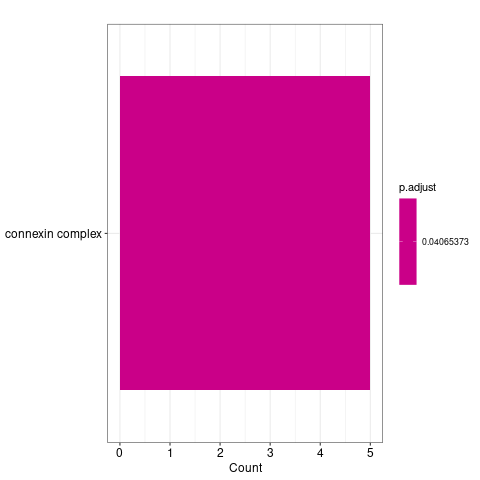

In [26]:
%%R -i recon_frame

data = recon_frame %>% filter(recon_1 != 0)

ref = data$name

top_500 = data$name[1:501]

# for cellular component
ego = enrichGO(gene = top_500,
               OrgDb = org.Hs.eg.db,
               universe = ref,
               ont = "CC",
               keyType = "SYMBOL")

barplot(ego)

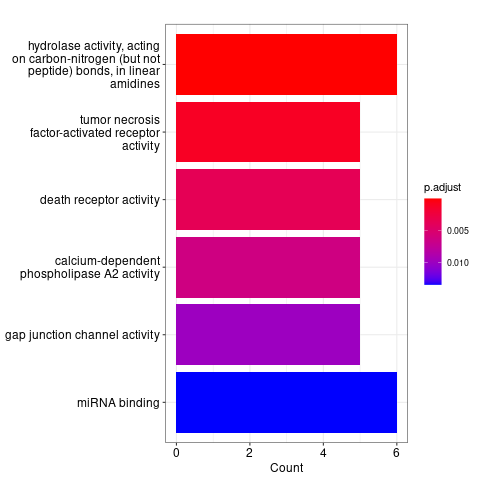

In [27]:
%%R
# and molecular function
ego = enrichGO(gene = top_500,
               OrgDb = org.Hs.eg.db,
               universe = ref,
               ont = "MF",
               keyType = "SYMBOL")

barplot(ego)

In [29]:
%%R
# and biological process:
ego = enrichGO(gene = top_500,
               OrgDb = org.Hs.eg.db,
               universe = ref,
               ont = "BP",
               keyType = "SYMBOL")

ego

#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 BP 
#...@keytype 	 SYMBOL 
#...@gene 	 chr [1:501] "OR4F5" "SAMD11" "NOC2L" "KLHL17" "PLEKHN1" "PERM1" "HES4" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...0 enriched terms found
#...Citation
 T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu.
 clusterProfiler 4.0: A universal enrichment tool for interpreting omics data.
 The Innovation. 2021, 2(3):100141 



### Network analysis

We can also look closer at the genes by plotting them as PPI network:

R[write to console]: versuche URL 'https://stringdb-static.org/download/protein.aliases.v11.5/9606.protein.aliases.v11.5.txt.gz'

R[write to console]: Content type 'application/octet-stream'
R[write to console]:  length 21726816 bytes (20.7 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console

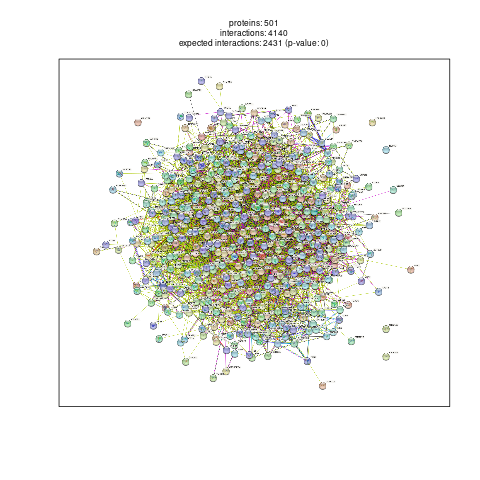

In [30]:
%%R
string_db = STRINGdb$new(species=9606,
                         score_threshold=200,
                         input_directory="")

top_500 = data.frame("gene"=top_500)

top_500_mapped = string_db$map(top_500, "gene", removeUnmappedRows = T)
string_db$plot_network(top_500)

Seems like we have a few heavy interconnected regions.

In [31]:
%%R
ntwrk <- string_db$get_subnetwork(top_500_mapped$STRING_id)

library('igraph')

R[write to console]: versuche URL 'https://stringdb-static.org/download/protein.links.v11.5/9606.protein.links.v11.5.txt.gz'

R[write to console]: Content type 'application/octet-stream'
R[write to console]:  length 72718210 bytes (69.3 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =

With igraph, let us have a look at some measures we can easily compute on the extracted network:

In [32]:
%%R
# 
order(betweenness(ntwrk))
mean_distance(ntwrk)
clique.number(ntwrk)

[1] 14


For a further analysis let's switch to the package `BioNAR`.
Let's have a look at how well our subnetwork follows the power-law:

R[write to console]: Lade nötiges Paket: poweRlaw

R[write to console]: Lade nötiges Paket: latex2exp

R[write to console]: Lade nötiges Paket: RSpectra

R[write to console]: Lade nötiges Paket: Rdpack

R[write to console]: Using 'localHub=TRUE'
  If offline, please also see BiocManager vignette section on offline use

R[write to console]: snapshotDate(): 2023-04-06

R[write to console]: loading from cache

R[write to console]: 
Attache Paket: ‘BioNAR’


R[write to console]: Das folgende Objekt ist maskiert ‘package:igraph’:

    permute




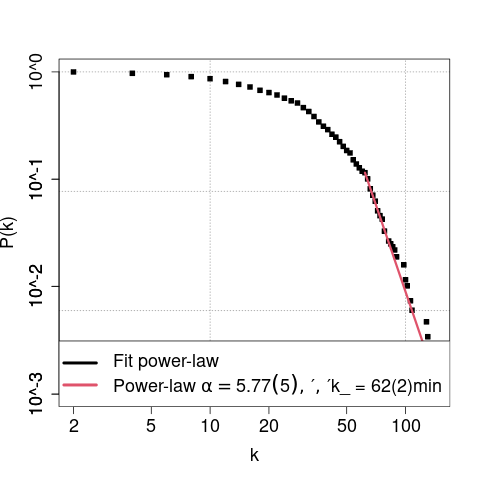

In [33]:
%%R
library('BioNAR')
clusters <- calcAllClustering(ntwrk)
pFit <- fitDegree( as.vector(igraph::degree(graph=clusters)),threads=1, Nsim=5,

                    plot=TRUE)

The package also allows us to identify clusters in the extracted list.
These clusters then can get extracted and be plotted clusterwise:

IGRAPH bb9018b UN-- 500 8280 -- 
+ attr: louvain (g/n), name (v/c), DEG (v/c), BET (v/c), CC (v/c), SL
| (v/c), mnSP (v/c), PR (v/c), sdSP (v/c), louvain (v/c),
| combined_score (e/n)


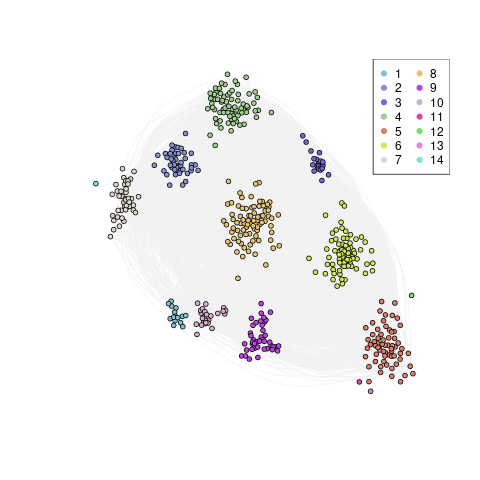

In [34]:
%%R
alg = "louvain"
library("randomcoloR")

clsuters <- calcCentrality(ntwrk)
getCentralityMatrix(clusters)
clusters <- calcClustering(clsuters, alg)
summary(clusters)
V(clusters)$louvain

mem_df <- data.frame(names=V(clusters)$name,membership=as.numeric(V(clusters)$louvain))

palette <- distinctColorPalette(max(as.numeric(mem_df$membership)))

lay <- layoutByCluster(clusters, mem_df,layout = layout_nicely)

plot(clusters,vertex.size=3,layout=lay,
        vertex.label=NA,
        vertex.color=palette[as.numeric(mem_df$membership)],
        edge.color='grey95')

legend('topright',legend=names(table(mem_df$membership)),
        col=palette,pch=19,ncol = 2)

Or by just by their community interactions:

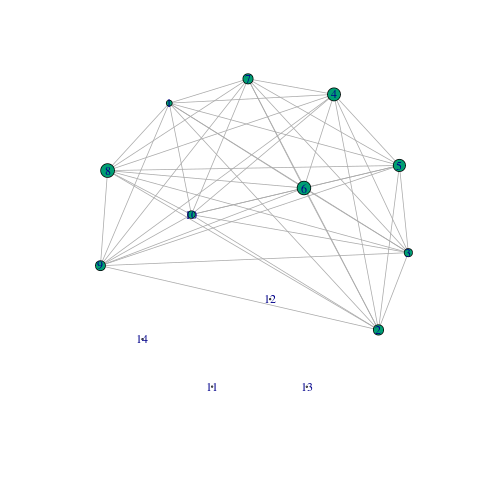

In [35]:
%%R
idx <- base::match( V(clusters)$name, mem_df$names)

cgg <- getCommunityGraph(clusters, mem_df$membership[idx])

D0 = unname(degree(cgg))

plot(cgg, vertex.size=sqrt(V(cgg)$size), vertex.cex = 0.8, vertex.color=round(log(D0)) + 1, layout=layout_with_kk, margin=0)

## Transcription factor enrichment

As we now have a ranked list with "important" genes, we can check if it's significantly enriched in transcription-factors:

In [44]:
from evaluation_methods.fisher_exact_for_gene_lists import f_exact_test
data = pd.read_csv("recons/GTEx_filtereded_with_genes_in_string.csv")
data = data.loc[data["recon_1"] != 0]
top_100 = data.iloc[0:100]
f_exact_test(set(top_100["name"]), set(data["name"]))

[SignificanceResult(statistic=0.45654579612425045, pvalue=0.4492893027160949),
 [[2, 793], [98, 17740]]]

To get an idea, about how the p-value will change over the ordered list of errors, we simply:

In [40]:
import matplotlib.pyplot as plt

In [41]:
plist = []

for genes in range(0, 1300):
    top = data.iloc[0:genes]
    results = f_exact_test(set(top["name"]), set(data["name"]))
    plist.append(results[0][1])

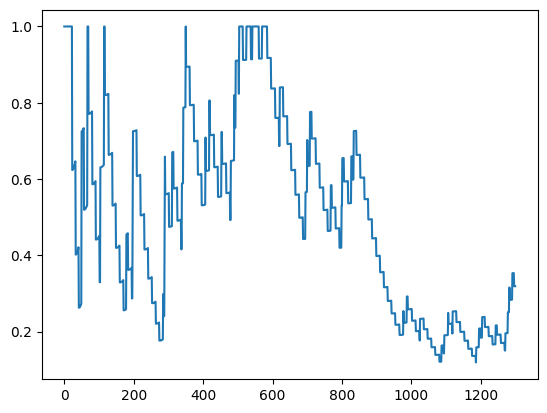

In [42]:
plt.plot(plist)

# Training with large files using a data generator

If we want to work with large datasets, the `DataGenerator`-class implements everything needed to read from an h5 file, for training directly.
This can come in handy for example when the RAM of the used computer is too small to load a whole set at once.
With the generator you're able to shuffle the data between the batches, that can be useful in case one wants to iterate over the same data multiple times.
The class has left some space for batch wise pre-processing.
In this case we use a log-normalized and scaled version of the `EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv` dataset from `https://gdc.cancer.gov/about-data/publications/pancanatlas`.
To use it with the data generator:

In [ ]:
import h5py
from class_definitions import generic_VAE
from class_definitions import data_handler
import numpy as np


# get information about the shape:
data = h5py.File("./data/EBPlusPlusAdjustPANCAN.h5").get("transposed_data")
# and define the generator
data_train = data_handler.DataGenerator(dataset_name="transposed_data", 
                                        filepath="./data/EBPlusPlusAdjustPANCAN.h5",
                                        # batch size hereby  
                                        batch_size=10,
                                        # shuffel the data
                                        shuffle=True)
input_dims = data[0].shape[0]

# build a VAE:
vae_build = generic_VAE.Builder(
        input_dims,
        # using a deeper model than before
        [10000, 1000, 500],
        [10000, 1000, 500],
        100,
        dropout_rate=.01)

# make it a Model:
vae_model = generic_VAE.VAE(vae_build)

# complile it:
vae_model.compile()

# for the amount of batches:
batch_size = int(np.floor(input_dims / 100))

# vae_model.fit(data, batch_size=batch_size)
vae_model.fit(data_train)

# Filters applied prior training

In the introduction we simply searched for all genes, that were present in the STRINGdb database.
This lead to a latent space, learned from the feature data.
However this data was filtered prior to training, therefor we introduced a bias.

Using this bias to focus on a particular group of genes can come in handy.
A GO-term mapping a certain process for example is a great filter as we can specify gene products with it, that are known to be a part of it.

For example counts the GO-term `GO:0006355` specifies the process of *regulation of DNA-templated transcription* and counts currently 21'789'333 annotations.
The term `GO:0008134` specifies *transcription factor binding* and counts 96'125 annotations.

## define a Filter

We can get the names of genes (for *Homo sapiens*) annotated to these terms by using R again:

In [45]:
%%R -o trans_assoc_genes
library(GO.db)
library(org.Hs.eg.db)

# the ID's
go_id = "GO:0006355"
tf_bnd_id = "GO:0008134"

# to get the genes annotated to the terms above
allegs = get(go_id, org.Hs.egGO2ALLEGS)
genes = unlist(mget(allegs,org.Hs.egSYMBOL))

allegs = get(tf_bnd_id, org.Hs.egGO2ALLEGS)
tf_bnd_genes = unlist(mget(allegs, org.Hs.egSYMBOL))

trans_assoc_genes = c(tf_bnd_genes, genes)

To get arid of redundancies we'll simply make it a set:

In [46]:
trans_assoc_genes = set(trans_assoc_genes)

## How to use the Filter

To apply this list of genes as a filter to the already used GTEx dataset we just:

In [47]:
data = pd.read_hdf("data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.h5", key = "data")
data = data.loc[data["Description"].isin(trans_assoc_genes)]

## Model fitting

This datset now can undergo some pre-processing, this time we will also remove genes that count less than 17383 reads per gene for all samples.
And in the next step we use it to fit a VAE-model:

In [48]:
data = data.drop(data[data.iloc[:, 2:].sum(axis=1) < 17383].index)

fdat = np.array(data)

logdat = prep.log_norm(np.array(fdat)[:, 2:])

sdat = prep.scale_by_sample(logdat)

input_shape = sdat.T.shape[1]
vae = gvae.Builder(input_shape=input_shape,
                   encoder_shape=[186],
                   decoder_shape=[186],
                   latent_dims=18,
                   dropout_rate=.001)

vae = gvae.VAE(vae)

# compile it:
vae.compile()

# and train it:
vae.fit(sdat.T, epochs=100, workers=64, use_multiprocessing=True)

Epoch 1/100
544/544 [==============================] - 4s 7ms/step - loss: 246.3428 - reconstruction_loss: 0.8864 - kl_loss: 245.4564
Epoch 2/100
544/544 [==============================] - 4s 7ms/step - loss: 0.5900 - reconstruction_loss: 0.5899 - kl_loss: 1.1524e-04
Epoch 3/100
544/544 [==============================] - 4s 7ms/step - loss: 0.5775 - reconstruction_loss: 0.5774 - kl_loss: 1.0750e-04
Epoch 4/100
544/544 [==============================] - 4s 7ms/step - loss: 0.5750 - reconstruction_loss: 0.5749 - kl_loss: 1.0661e-04
Epoch 5/100
544/544 [==============================] - 4s 7ms/step - loss: 0.5748 - reconstruction_loss: 0.5747 - kl_loss: 1.0614e-04
Epoch 6/100
544/544 [==============================] - 4s 7ms/step - loss: 0.5745 - reconstruction_loss: 0.5744 - kl_loss: 1.0584e-04
Epoch 7/100
544/544 [==============================] - 4s 7ms/step - loss: 0.5746 - reconstruction_loss: 0.5745 - kl_loss: 1.0585e-04
Epoch 8/100
544/544 [==============================] - 4s 7ms/

In [49]:
recons = vae.fwise_recon_error_tracker.result().numpy()
recon_frame = pd.DataFrame({"name" : data["Description"], "recon_1" : recons}).sort_values(by="recon_1")

## Further analysis

Like we already did.

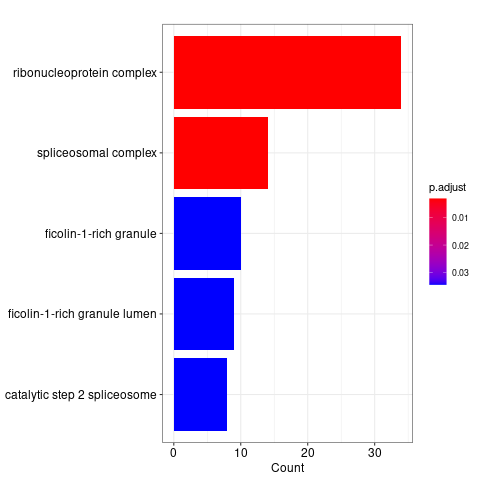

In [50]:
%%R -i recon_frame
ref = recon_frame$name

top_500 = recon_frame$name[1:501]

# for cellular component
ego = enrichGO(gene = top_500,
               OrgDb = org.Hs.eg.db,
               universe = ref,
               ont = "CC",
               keyType = "SYMBOL")
barplot(ego)

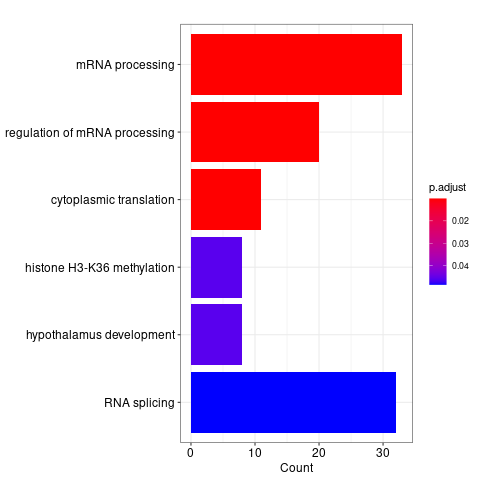

In [51]:
%%R
# for BP
ego = enrichGO(gene = top_500,
               OrgDb = org.Hs.eg.db,
               universe = ref,
               ont = "BP",
               keyType = "SYMBOL")
barplot(ego)

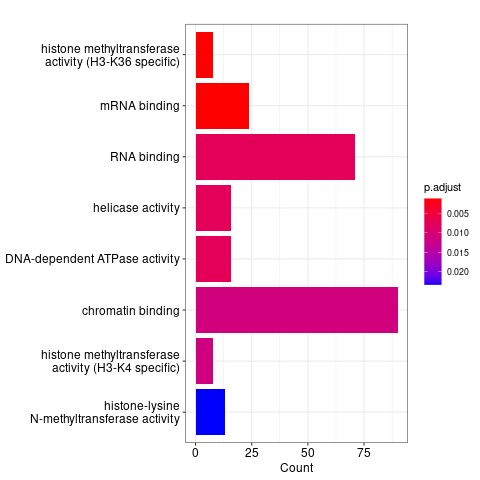

In [52]:
%%R
# for MF
ego = enrichGO(gene = top_500,
               OrgDb = org.Hs.eg.db,
               universe = ref,
               ont = "MF",
               keyType = "SYMBOL")
barplot(ego)

R[write to console]: Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

R[write to console]: Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...

R[write to console]: Some genenames not mapped to entrez ids! Replaced with their original input



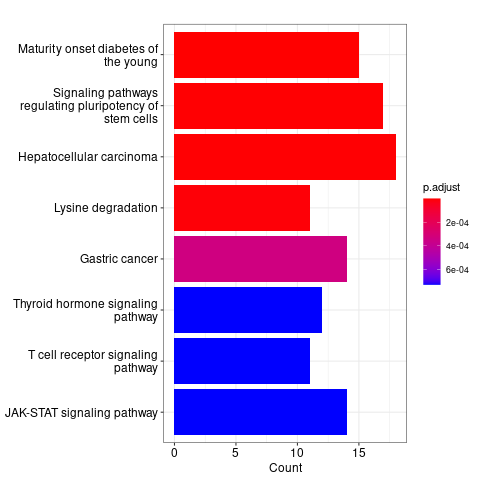

In [53]:
%%R
library('MOMA')

ekegg = enrichKEGG(gene = mapHugo(top_500),
                   organism="hsa")
barplot(ekegg)

For the computation of the p-values used in the fishers exact test, the defaulted list holds transcription factors from *Mus musculus* and *Homo sapiens*.
If one want's to focus on different sets, simply hand them directly:

In [54]:
tfs_list = pd.read_csv("evaluation_methods/trrust_rawdata.human.tsv", sep="\t")
# remove redundancies:
tfs = set(tfs_list["AATF"])

In [55]:
import evaluation_methods.fisher_exact_for_gene_lists as ftest
data = recon_frame.loc[recon_frame["recon_1"] != 0]
top_100 = recon_frame.iloc[0:100]
ftest.f_exact_test(set(top_100["name"]), set(recon_frame["name"]), tfs)

[SignificanceResult(statistic=0.4393939393939394, pvalue=0.005476352185505544),
 [[12, 783], [88, 2523]]]

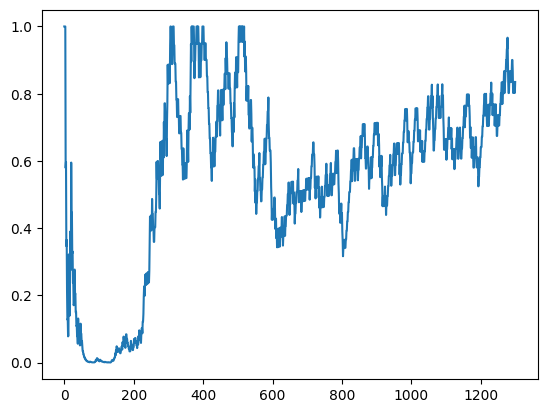

In [56]:
top_500 = recon_frame.iloc[0:500]
ftest.f_exact_test(set(top_500["name"]), set(recon_frame["name"]), tfs)

plist = []

for genes in range(0, 1300):
    top = recon_frame.iloc[0:genes]
    results = ftest.f_exact_test(set(top["name"]), set(recon_frame["name"]), tfs)
    plist.append(results[0][1])

plt.plot(plist)

As we're interested in the tf's, that have the lowest reconstruction error, we need to get an idea, where our list needs to be cut off:

In [57]:
idx = plist.index(min(plist))
top_of_the_pops = data[0:idx]

To get some more knowledge regarding the function of these transcription factors, lets extract them:

tfs_in_tops = tfs & set(top_of_the_pops)

# Comparing two similar sets

The data sets under `https://doi.org/10.1038/sdata.2018.61` supply us with data for cancer and normal tissue RNA-seq data.
From there we downloaded breast cancer data of normal tissue from and also tumor tissue.

In [77]:
# the cancer data:
brca = pd.read_csv("/home/test/Downloads/brcarsemfpkmtcgat-tumor.txt.gz", sep="\t")
# the normal data from gtex:
gtex = pd.read_csv("/home/test/Downloads/breastrsemfpkmgtex.txt.gz", sep="\t")
# and the normal data from tcga
ntgc = pd.read_csv("/home/test/Downloads/brcarsemfpkmtcga.txt.gz", sep="\t")
# and join the normal data:
normal = pd.concat([gtex, ntgc]).fillna(0)

These now can be used for training VAEs, but at first the pre-processing takes place:

## On the normal data

In [78]:
normal = normal.loc[normal["Hugo_Symbol"].isin(trans_assoc_genes)]
data = normal.drop(normal[normal.iloc[:, 2:].sum(axis=1) < 201].index)
fdat = np.array(data)

logdat = prep.log_norm(np.array(fdat)[:, 2:])

sdat = prep.scale_by_sample(logdat)

input_shape = sdat.T.shape[1]
vae = gvae.Builder(input_shape=input_shape,
                   encoder_shape=[500],
                   decoder_shape=[500],
                   latent_dims=100)

vae = gvae.VAE(vae)

# compile it:
vae.compile()

# and train it:
vae.fit(sdat.T, epochs=10, batch_size=200 , workers=64, use_multiprocessing=True)
# extract the recons:
recons = vae.fwise_recon_error_tracker.result().numpy()
recon_frame = pd.DataFrame({"name" : data["Hugo_Symbol"], "recon_1" : recons}).sort_values(by="recon_1")

Epoch 1/10
1/1 [==============================] - 1s 562ms/step - loss: 8520.9805 - reconstruction_loss: 3.5811 - kl_loss: 8517.3994
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 270139552.0000 - reconstruction_loss: 7.4758 - kl_loss: 270139552.0000
Epoch 3/10
1/1 [==============================] - 0s 52ms/step - loss: 75916416.0000 - reconstruction_loss: 7.4562 - kl_loss: 75916408.0000
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 993419.6875 - reconstruction_loss: 5.9114 - kl_loss: 993413.7500
Epoch 5/10
1/1 [==============================] - 0s 57ms/step - loss: 310786.0000 - reconstruction_loss: 4.2819 - kl_loss: 310781.7188
Epoch 6/10
1/1 [==============================] - 0s 53ms/step - loss: 253208.3281 - reconstruction_loss: 3.3615 - kl_loss: 253204.9688
Epoch 7/10
1/1 [==============================] - 0s 58ms/step - loss: 215109.6875 - reconstruction_loss: 2.7965 - kl_loss: 215106.8906
Epoch 8/10
1/1 [=========================

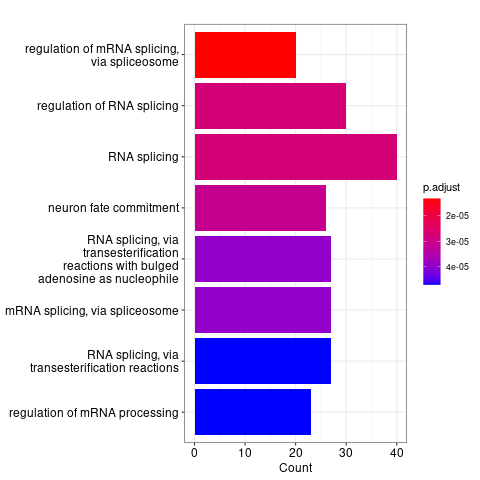

In [71]:
%%R -i recon_frame -o top_500

data = recon_frame %>% filter(recon_1 != 0)

ref = data$name

top_500 = data$name[1:501]

# for cellular component
ego = enrichGO(gene = top_500,
               OrgDb = org.Hs.eg.db,
               universe = ref,
               ont = "BP",
               keyType = "SYMBOL")

barplot(ego)

In [80]:
tfs_in_normal = set(top_500) & tfs
len(tfs_in_normal)

114

## Cancer-data

In [81]:
tumor = brca.loc[brca["Hugo_Symbol"].isin(trans_assoc_genes)]
data = tumor.fillna(0)
data = tumor.drop(tumor[tumor.iloc[:, 2:].sum(axis=1) < 201].index)
fdat = np.array(data)

logdat = prep.log_norm(np.array(fdat)[:, 2:])

sdat = prep.scale_by_sample(logdat)

input_shape = sdat.T.shape[1]
vae = gvae.Builder(input_shape=input_shape,
                   encoder_shape=[500],
                   decoder_shape=[500],
                   latent_dims=100)

vae = gvae.VAE(vae)

# compile it:
vae.compile()

# and train it:
vae.fit(sdat.T, epochs=40, workers=64, use_multiprocessing=True)
# extract the recons:
recons = vae.fwise_recon_error_tracker.result().numpy()
recon_frame = pd.DataFrame({"name" : data["Hugo_Symbol"], "recon_1" : recons}).sort_values(by="recon_1")

Epoch 1/40
31/31 [==============================] - 1s 18ms/step - loss: 390235.4668 - reconstruction_loss: 3.1220 - kl_loss: 390232.2592
Epoch 2/40
31/31 [==============================] - 1s 16ms/step - loss: 558.7489 - reconstruction_loss: 0.7571 - kl_loss: 557.9918
Epoch 3/40
31/31 [==============================] - 1s 17ms/step - loss: 495.2366 - reconstruction_loss: 0.7181 - kl_loss: 494.5184
Epoch 4/40
31/31 [==============================] - 1s 16ms/step - loss: 521.7402 - reconstruction_loss: 0.6950 - kl_loss: 521.0451
Epoch 5/40
31/31 [==============================] - 1s 16ms/step - loss: 1225.2659 - reconstruction_loss: 0.7337 - kl_loss: 1224.5323
Epoch 6/40
31/31 [==============================] - 1s 17ms/step - loss: 1080.9776 - reconstruction_loss: 0.7020 - kl_loss: 1080.2757
Epoch 7/40
31/31 [==============================] - 1s 17ms/step - loss: 704.5603 - reconstruction_loss: 0.6556 - kl_loss: 703.9047
Epoch 8/40
31/31 [==============================] - 1s 16ms/step -

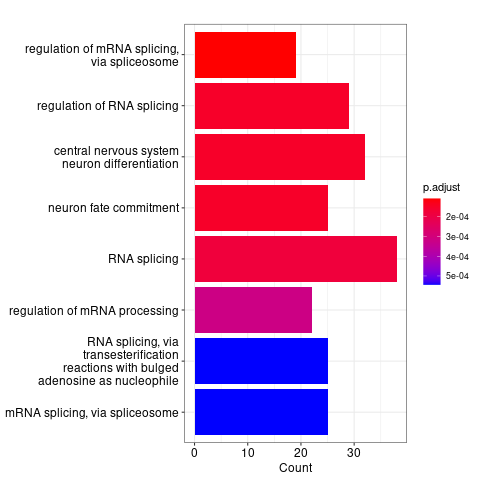

In [83]:
%%R -i recon_frame -o top_500

data = recon_frame %>% filter(recon_1 != 0)

ref = data$name

top_500 = data$name[1:501]

# for cellular component
ego = enrichGO(gene = top_500,
               OrgDb = org.Hs.eg.db,
               universe = ref,
               ont = "BP",
               keyType = "SYMBOL")

barplot(ego)

lets have a look at the differences between the top 500 recons:

In [84]:
tfs_in_cancer = set(top_500) & tfs
len(tfs_in_cancer)

tfs_in_cancer.difference(tfs_in_normal)

{'DAXX', 'NR1H2', 'PBX2', 'RFXANK', 'ZNF76'}

# VAE-Architecture

Most of the scenarios above were optimized with interactive processes.
The architecture in the beginning was kept as shallow as possible.
As a rough guideline one can reduce the amounts of neurons at the beginning with 2-3 times the power of ten and create a latent layer of a size between 100 and 10 neurons.
If this does not lead to a sufficient outcome under a training considering all sample-sets once, the VAE can usually achieve better results by adding another hidden layer.
It's important to notice, that this can have an impact to the final ranking of genes by their reconstruction errors.